<a href="https://colab.research.google.com/github/rhaymisonbetini/generate-faces/blob/main/generate_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

API_KEY = "31a0784f84e95cfe5c569b7f8de53fc8b595da1f"

def show(tensor, num=25, wandb=0,name=""):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow=5).permute(1,2,0)

  #optional
  if(wandb == 1 and wandbact==1):
    wandb.log({name:wandb.Image(grid.numpy().clip(0.1))})

  plt.imshow(grid.clip(0,1))
  plt.show()

#hyperparameters
n_epochs = 10000
batch_size=128
lr=1e-4
z_dim=200
device="cpu"

cur_step=0
crit_cycles=5
gen_lossess=[]
crit_lossess=[]
show_step=35
save_step=35

wandbact=1



In [3]:
###optional
!pip install wandb -qqq
import wandb
wandb.login(key=API_KEY)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
%%capture
experiment_name = wandb.util.generate_id()
myrun=wandb.init(
    project="generate-faces-gan",
    group=experiment_name,
    config={
        "optimize":"sgd",
        "model":"wgan gp",
        "epoch":"1000",
        "batch_size":128
    }
)

condig =wandb.config


In [ ]:
print(experiment_name)

z81ojn7p


In [24]:
#negerator model

class Generator(nn.Module):
  def __init__(self,z_dim=64,d_dim=16):
    super(Generator, self).__init__()
    self.z_dim = z_dim

    self.gen = nn.Sequential(

        nn.ConvTranspose2d(z_dim,d_dim*32,4,1,0),
        nn.BatchNorm2d(d_dim * 32),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*32,d_dim*16,4,2,1),
        nn.BatchNorm2d(d_dim * 16),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*16,d_dim*8,4,2,1),
        nn.BatchNorm2d(d_dim * 8),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*8,d_dim*4,4,2,1),
        nn.BatchNorm2d(d_dim * 4),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*4,d_dim*2,4,2,1),
        nn.BatchNorm2d(d_dim * 2),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*2,3,4,2,1),
        nn.Tanh()

    )

  def forward(self,noise):
    x=noise.view(len(noise),self.z_dim,1,1)
    return self.gen(x)

def gen_noise(num,z_dim, device="cpu"):
  return torch.randn(num,z_dim,device=device) #128X 200


In [26]:
## critic model

class Critic(nn.Module):
  def __init__(self,d_dim=16):
    super(Critic,self).__init__()

    self.crit = nn.Sequential(
        nn.Conv2d(3,d_dim,4,2,1),
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim,d_dim*2,4,2,1), ## 32x32
        nn.InstanceNorm2d(d_dim*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*2,d_dim*4,4,2,1), ## 16x16
        nn.InstanceNorm2d(d_dim*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*4,d_dim*8,4,2,1), ## 8x8
        nn.InstanceNorm2d(d_dim*8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*8,d_dim*16,4,2,1), ## 4x4
        nn.InstanceNorm2d(d_dim*16),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*16,1,4,1,0), #1x1
        nn.InstanceNorm2d(d_dim*16),
        nn.LeakyReLU(0.2)
    )

  def forward(self, image):
    crit_pred = self.crit(image)
    return crit_pred.view(len(crit_pred))


In [14]:
### LOAD_DATA_SET
import gdown, zipfile
from google.colab import drive

path="data/celeba/"


if not os.path.exists(path):
  os.makedirs(path)

with zipfile.ZipFile("/content/drive/MyDrive/img_align_celeba.zip",'r') as ziphandler:
  ziphandler.extractall(path)


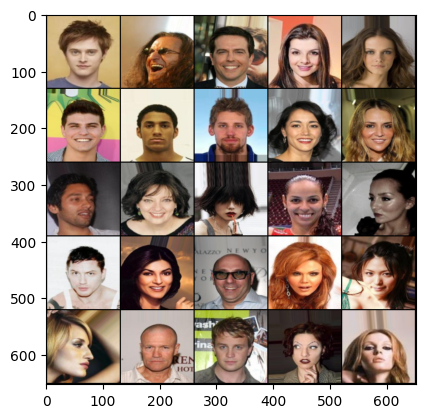

In [31]:
### Dataset, DataLoader

class Dataset(Dataset):
  def __init__(self,path,size=128, lim=10000):
    self.sizes=[size,size]
    items,labels=[],[]

    for data in os.listdir(path)[:1000]:
      item = os.path.join(path_celeba,data)
      items.append(item)
      labels.append(data)

    self.items=items
    self.labels=labels

  def __len__(self):
    return len(self.items)

  def __getitem__(self,idx):
    data = PIL.Image.open(self.items[idx]).convert("RGB")
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # 128x128
    data = np.transpose(data,(2,0,1)).astype(np.float32,copy=False)
    data = torch.from_numpy(data).div(255)
    return data,self.labels[idx]

## Dataset
path_celeba = "data/celeba/img_align_celeba/"
ds = Dataset(path_celeba, size=128, lim=10000)

## Dataloader

dataloader = DataLoader(ds,batch_size=batch_size,shuffle=True)

## Models

gen = Generator(z_dim).to(device)
crit = Critic().to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5,0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5,0.9))

if wandb == 1:
  wandb.watch(gen,log_freq=100)
  wandb.watch(crit,log_freq=100)


x,y=next(iter(dataloader))
show(x)
